## 1. DATA PRE-PROCESSING

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# ---------------------------------------------------
# convert the type of variables
# ---------------------------------------------------
def convert_to_category(df):
    """
    Convert object-type variables to category-type
    
    """
    
    df = df.copy()
    
    # select all the object-type variables
    object_columns = df.select_dtypes(include=['object']).columns
    
    # delete the space between letters and convert variables to category
    df.loc[:, object_columns] = df.loc[:, object_columns].apply(
        lambda x: x.str.replace(' ', '')
    ).astype('category')
    
    return df

#### LOAD DATA

In [2]:
data = pd.read_csv('/Users/junyuchen/Desktop/Master Thesis/code/data/gaa.csv', parse_dates=['vertrag'], index_col=['vertrag'], low_memory=False)

# date
print(f'Earliest: {data.sort_index().index.date.min()}, Latest: {data.sort_index().index.date.max()}.')
# house characteristics
print(f'Number of variables: {len(data.columns)}.')
print(data.columns)
print(f"Length of original dataset: {len(data)}, after dropping: {len(data.loc[data['alter'] > 0])}")
print(len(data) - len(data.loc[data['alter'] > 0]))
print(7264 / 37203)
data['stellung'].unique()
#data

Earliest: 1996-01-04, Latest: 2017-05-04.
Number of variables: 49.
Index(['bezirk', 'jahr', 'stadtlage', 'wohnlage', 'lage', 'wasserl', 'gtypbw',
       'blocklage', 'erschlbtrg', 'flaeche', 'sanier', 'typgfz', 'tnutzung',
       'vertragsart', 'vegruppe', 'ergruppe', 'verfueg', 'denkmal', 'baujahr',
       'note', 'heizung', 'foerder', 'gflaeche', 'wnflaeche', 'wflaeche',
       'leerstand', 'tatgfz', 'preisgflaeche', 'preiswnflaeche', 'preis',
       'stellung', 'ganzahl', 'keller', 'dachform', 'gkonstruktion',
       'ghinweis', 'dausbau', 'schwimmbad', 'perver', 'ungever', 'ungrundtat',
       'ungrund', 'origin', 'ortsteil', 'alter', 'quarter', 'kalender', 'mdid',
       'neubau'],
      dtype='object')
Length of original dataset: 37203, after dropping: 29939
7264
0.19525307098889874


array(['Doppelhaushaelfte', 'Freistehend/Einzelhaus', 'Reihenendhaus',
       'Reihenhaus'], dtype=object)

In [3]:
# select variables
data = data[['kalender', 'flaeche', 'gflaeche', 'alter', 'preis', 'stellung', 'baujahr']]
data.rename(
    columns = {
        'kalender' : 'period_string',
        'flaeche' : 'lot_size',
        'gflaeche' : 'floor_space',
        'alter' : 'age',
        'preis' : 'price'
    }, inplace=True)

print(f'\nOriginal number of observations: {len(data)}.')

# drop NaNs
data.dropna(inplace=True)
print(f'\nNumber of observations after dropping NANs: {len(data)}.')

# convert the type of variables
data = convert_to_category(data)
data


Original number of observations: 37203.

Number of observations after dropping NANs: 37203.


,period_string,lot_size,floor_space,age,price,stellung,baujahr
vertrag,,,,,,,
1996-02-01,1996q1,480,120,65,242864,Doppelhaushaelfte,1931
1996-04-23,1996q2,691,151,61,127823,Freistehend/Einzelhaus,1935
1996-09-20,1996q3,888,164,46,224968,Freistehend/Einzelhaus,1950
1996-02-20,1996q1,750,196,60,178952,Doppelhaushaelfte,1936
1996-04-24,1996q2,1105,163,66,230081,Freistehend/Einzelhaus,1930
...,...,...,...,...,...,...,...
2017-03-31,2017q1,637,104,53,280000,Freistehend/Einzelhaus,1964
2017-04-21,2017q2,497,105,83,240000,Freistehend/Einzelhaus,1934
2017-04-18,2017q2,144,131,18,425000,Reihenhaus,1999


#### DROP 0 and -1

In [4]:
# 1. drop negative "alter"
data = data.loc[data["age"] > 0]
print(f'\nNumber of observations after dropping negative "alter": {len(data)}.')


Number of observations after dropping negative "alter": 29939.


#### DROP 2017q2

In [5]:
data.index = data.index.to_period('Q').rename('period')
print(f'Original data: \n{data.index.value_counts().sort_values()}')

Original data: 
2017Q2     39
1997Q1    192
2003Q1    198
1996Q1    201
2006Q1    206
         ... 
2010Q3    484
2010Q2    486
2011Q2    492
2006Q4    497
2005Q4    637
Freq: Q-DEC, Name: period, Length: 86, dtype: int64


In [6]:
def select_observations(group):
    return group.sample(n=N, random_state=999)

# 2. drop 2017q2
data = data.loc[data['period_string'] != '2017q2', :]
print(f'\nNumber of observations after dropping "2017q2": {len(data)}.')

# select the first N observations of each quarter
N = data.index.value_counts().sort_values()[0]
data = data.groupby(data.index).apply(select_observations).reset_index(level=0, drop=True)

print(f"\nThe total number of observations after dropping missing observations: {len(data)}.")
print(data.index.value_counts().sort_values())


Number of observations after dropping "2017q2": 29900.

The total number of observations after dropping missing observations: 16320.
1996Q1    192
1997Q1    192
1997Q2    192
1997Q3    192
1997Q4    192
         ... 
2016Q4    192
2012Q3    192
2012Q2    192
2015Q2    192
2017Q1    192
Freq: Q-DEC, Name: period, Length: 85, dtype: int64


#### Examine Distribution of Each Variable

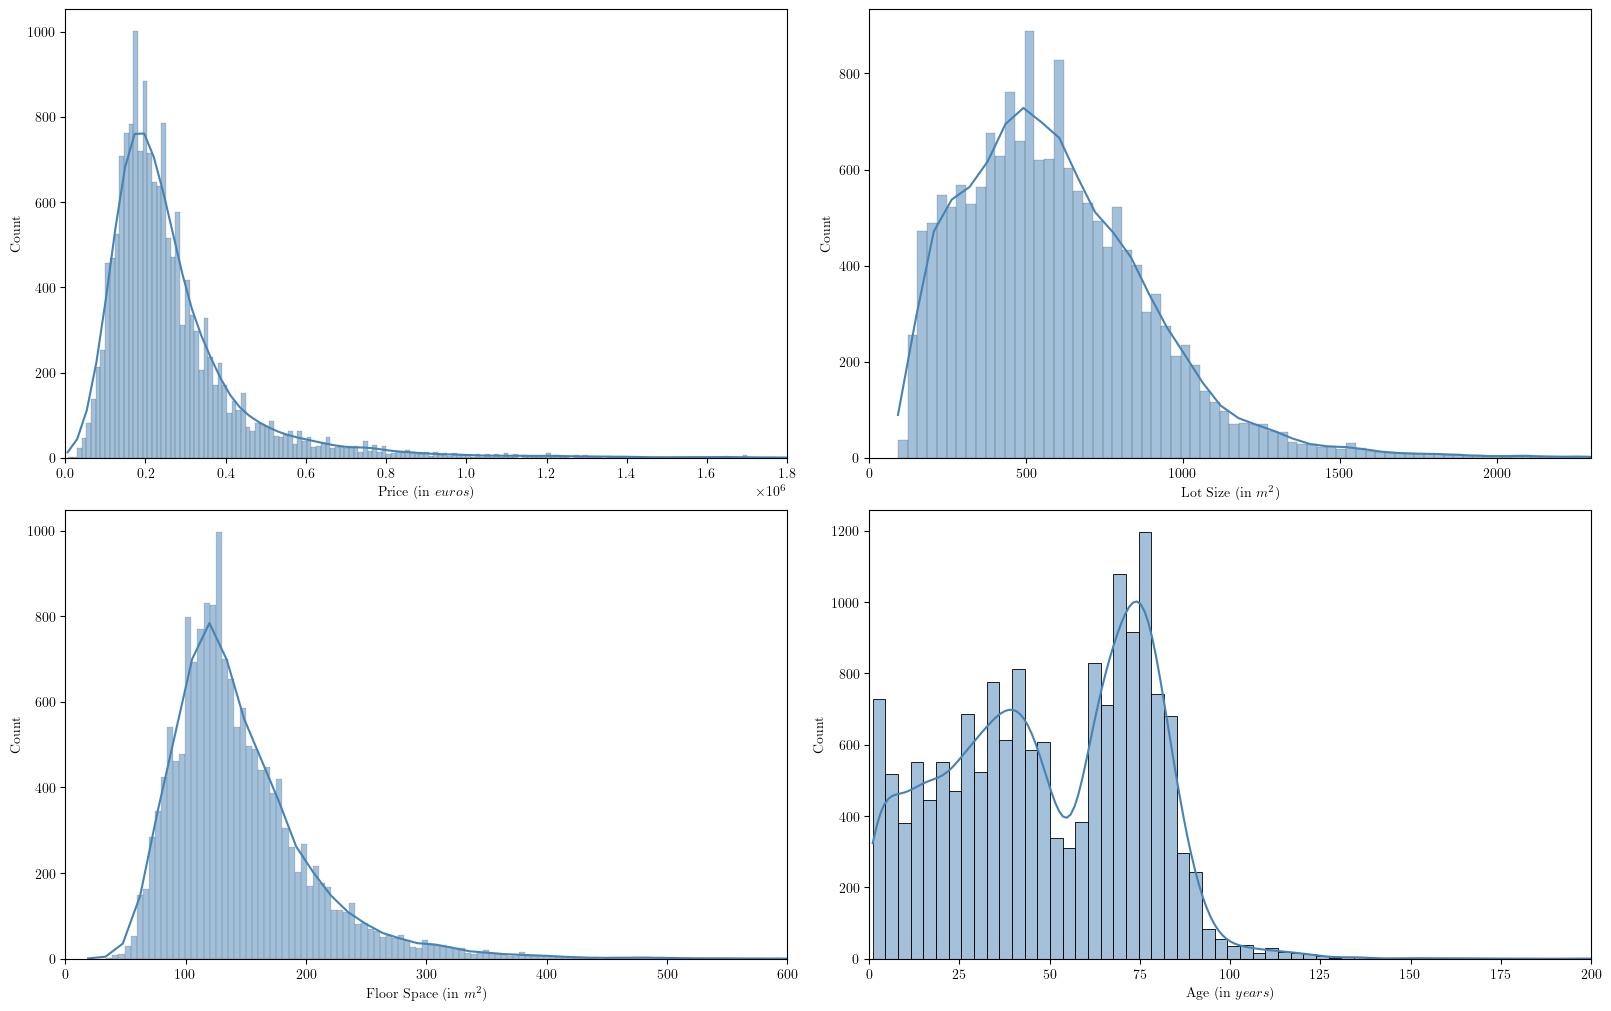

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(16,10), layout="constrained")
color = 'steelblue'

sns.histplot(data=data['price'], kde=True, ax=ax[0,0], color=color)
sns.histplot(data=data['lot_size'], kde=True, ax=ax[0,1], color=color)
sns.histplot(data=data['floor_space'], kde=True, ax=ax[1,0], color=color)
sns.histplot(data=data['age'], kde=True, ax=ax[1,1], color=color)

ax[0,0].set_xlim(0,1800000)
ax[0,1].set_xlim(0,2300)
ax[1,0].set_xlim(0,600)
ax[1,1].set_xlim(0,200)

ax[0,0].set_xlabel('Price (in $euros$)')
ax[0,1].set_xlabel('Lot Size (in $m^2$)')
ax[1,0].set_xlabel('Floor Space (in $m^2$)')
ax[1,1].set_xlabel('Age (in $years$)')

#plt.savefig('Plots/distribution_linear.png')
plt.show()

In [8]:
print(data.describe().round(2))

       lot_size  floor_space       age       price   baujahr
count  16320.00     16320.00  16320.00    16320.00  16320.00
mean     599.05       146.22     49.74   275208.84   1956.39
std      330.87        66.47     26.85   213880.19     27.02
min       92.00        19.00      1.00     6000.00   1800.00
25%      377.00       107.00     28.00   163613.00   1934.00
50%      554.00       133.00     50.00   222000.00   1958.00
75%      771.00       171.00     73.00   311888.00   1977.00
max    11450.00      2885.00    215.00  4750000.00   2015.00


<AxesSubplot:xlabel='baujahr', ylabel='Count'>

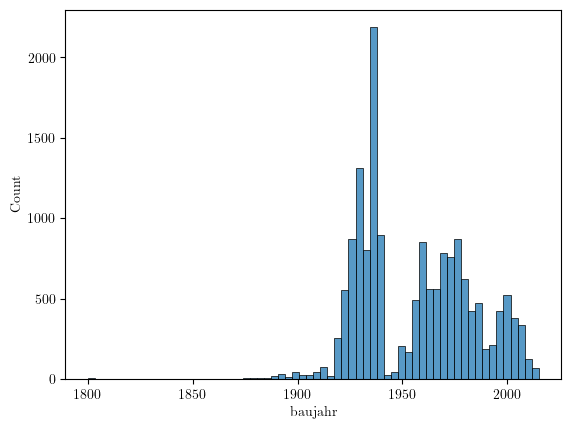

In [9]:
data_age = data.loc[(data["age"] > 60) & (data["age"] < 72)]
#data_baujahr
sns.histplot(data['baujahr'])

### Logarithm Transformation of Variables

In [10]:
data_log = data.copy()
data_log.loc[:, [
    'lot_size', 'floor_space', 'age', 'price'
]] = np.log(data_log.loc[:, [
    'lot_size', 'floor_space', 'age', 'price'
]])

print(len(data_log))
print(data_log.describe().round(2))
data_log.head()

16320
       lot_size  floor_space       age     price   baujahr
count  16320.00     16320.00  16320.00  16320.00  16320.00
mean       6.26         4.91      3.64     12.35   1956.39
std        0.54         0.37      0.93      0.56     27.02
min        4.52         2.94      0.00      8.70   1800.00
25%        5.93         4.67      3.33     12.01   1934.00
50%        6.32         4.89      3.91     12.31   1958.00
75%        6.65         5.14      4.29     12.65   1977.00
max        9.35         7.97      5.37     15.37   2015.00


,period_string,lot_size,floor_space,age,price,stellung,baujahr
period,,,,,,,
1996Q1,1996q1,6.815640,4.382027,4.060443,12.555909,Freistehend/Einzelhaus,1938
1996Q1,1996q1,6.642487,5.087596,4.442651,12.451549,Freistehend/Einzelhaus,1911
1996Q1,1996q1,6.291569,4.948760,4.077537,12.421091,Freistehend/Einzelhaus,1937
1996Q1,1996q1,5.631212,4.948760,2.890372,12.650399,Reihenendhaus,1978
1996Q1,1996q1,5.993961,5.135798,4.330733,12.118869,Freistehend/Einzelhaus,1920


#### Examine Distributions

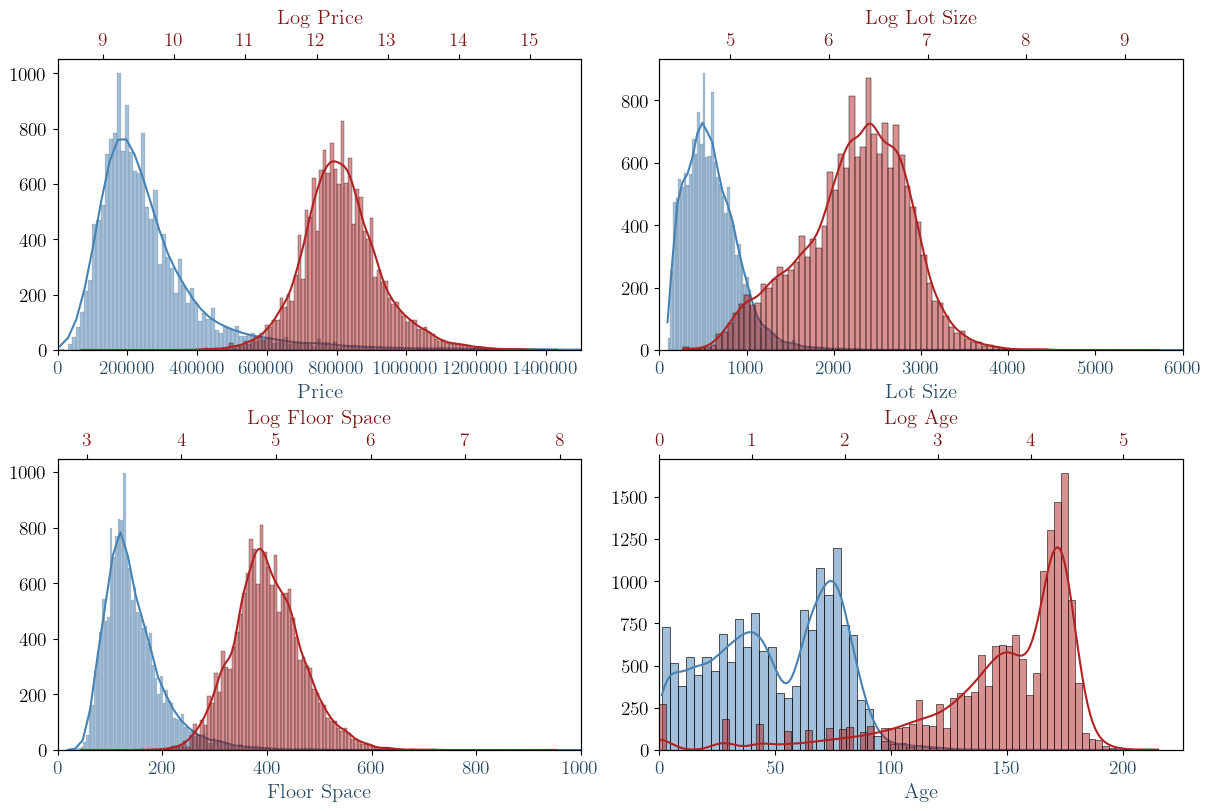

In [11]:
# Create a figure and axis
color1='steelblue'
color2='firebrick'
color_axis= '#294c69'
color_axis2= '#7b1717'
fs=15
ls=14

fig, ax = plt.subplots(2, 2, figsize=(12, 8), layout='constrained')

# ------------------------------------
# linear price
sns.histplot(data=data['price'], kde=True, color=color1, ax=ax[0,0])
ax[0,0].set_xlim(0,1500000)
ax[0,0].set_xlabel('Price', color=color_axis, fontsize=fs)
#ax[0,0].set_title('Price', y=1.07, fontsize=fs)
ax[0,0].tick_params(axis='x', labelcolor=color_axis, labelsize=ls)
ax[0,0].tick_params(axis='y', labelsize=ls)
ax[0,0].ticklabel_format(useOffset=False, style='plain')
ax[0,0].set_ylabel(None)
#ax[0,0].set_xlabel(None)

ax1 = ax[0,0].twiny()

# log price
sns.histplot(data=data_log['price'], kde=True, color=color2, ax=ax1)
ax1.set_xlabel('Log Price', color=color_axis2, fontsize=fs)
ax1.xaxis.set_label_coords(0.5, 1.12)
ax1.tick_params(axis='x', labelcolor=color_axis2, labelsize=ls)
ax1.set_ylabel(None)
#ax1.set_xlabel(None)

# ------------------------------------
# linear lot size
sns.histplot(data=data['lot_size'], kde=True, color=color1, ax=ax[0,1])
ax[0,1].set_xlim(0,6000)
ax[0,1].set_xlabel('Lot Size', color=color_axis, fontsize=fs)
#ax[0,1].set_title('Lot Size', y=1.07, fontsize=fs)
ax[0,1].tick_params(axis='x', labelcolor=color_axis, labelsize=ls)
ax[0,1].tick_params(axis='y', labelsize=ls)
ax[0,1].ticklabel_format(useOffset=False, style='plain')
ax[0,1].set_ylabel(None)
#ax[0,1].set_xlabel(None)

ax2 = ax[0,1].twiny()

# log price
sns.histplot(data=data_log['lot_size'], kde=True, color=color2, ax=ax2)
ax2.set_xlabel('Log Lot Size', color=color_axis2, fontsize=fs)
ax2.xaxis.set_label_coords(0.5, 1.12)
ax2.tick_params(axis='x', labelcolor=color_axis2, labelsize=ls)
ax2.set_ylabel(None)
#ax2.set_xlabel(None)

# ------------------------------------
# linear floor space
sns.histplot(data=data['floor_space'], kde=True, color=color1, ax=ax[1,0])
ax[1,0].set_xlim(0,1000)
ax[1,0].set_xlabel('Floor Space', color=color_axis, fontsize=fs)
#ax[1,0].set_title('Floor Space', y=1.07, fontsize=fs)
ax[1,0].tick_params(axis='x', labelcolor=color_axis, labelsize=ls)
ax[1,0].tick_params(axis='y', labelsize=ls)
ax[1,0].ticklabel_format(useOffset=False, style='plain')
ax[1,0].set_ylabel(None)
#ax[1,0].set_xlabel(None)

ax3 = ax[1,0].twiny()

# log price
sns.histplot(data=data_log['floor_space'], kde=True, color=color2, ax=ax3)
ax3.set_xlabel('Log Floor Space', color=color_axis2, fontsize=fs)
ax3.xaxis.set_label_coords(0.5, 1.12)
ax3.tick_params(axis='x', labelcolor=color_axis2, labelsize=ls)
ax3.set_ylabel(None)
#ax3.set_xlabel(None)

# ------------------------------------
# linear age
sns.histplot(data=data['age'], kde=True, color=color1, ax=ax[1,1])
ax[1,1].set_xlim(0)
ax[1,1].set_xlabel('Age', color=color_axis, fontsize=fs)
#ax[1,1].set_title('Age', y=1.07, fontsize=fs)
ax[1,1].tick_params(axis='x', labelcolor=color_axis, labelsize=ls)
ax[1,1].tick_params(axis='y', labelsize=ls)
ax[1,1].ticklabel_format(useOffset=False, style='plain')
ax[1,1].set_ylabel(None)
#ax[1,1].set_xlabel(None)

ax4 = ax[1,1].twiny()

# log price
sns.histplot(data=data_log['age'], kde=True, color=color2, ax=ax4)
ax4.set_xlim(0)
ax4.set_xlabel('Log Age', color=color_axis2, fontsize=fs)
ax4.xaxis.set_label_coords(0.5, 1.12)
ax4.tick_params(axis='x', labelcolor=color_axis2, labelsize=ls)
ax4.set_ylabel(None)
#ax4.set_xlabel(None)

plt.savefig('Plots/variable_distributions.png', dpi=600)
plt.show()

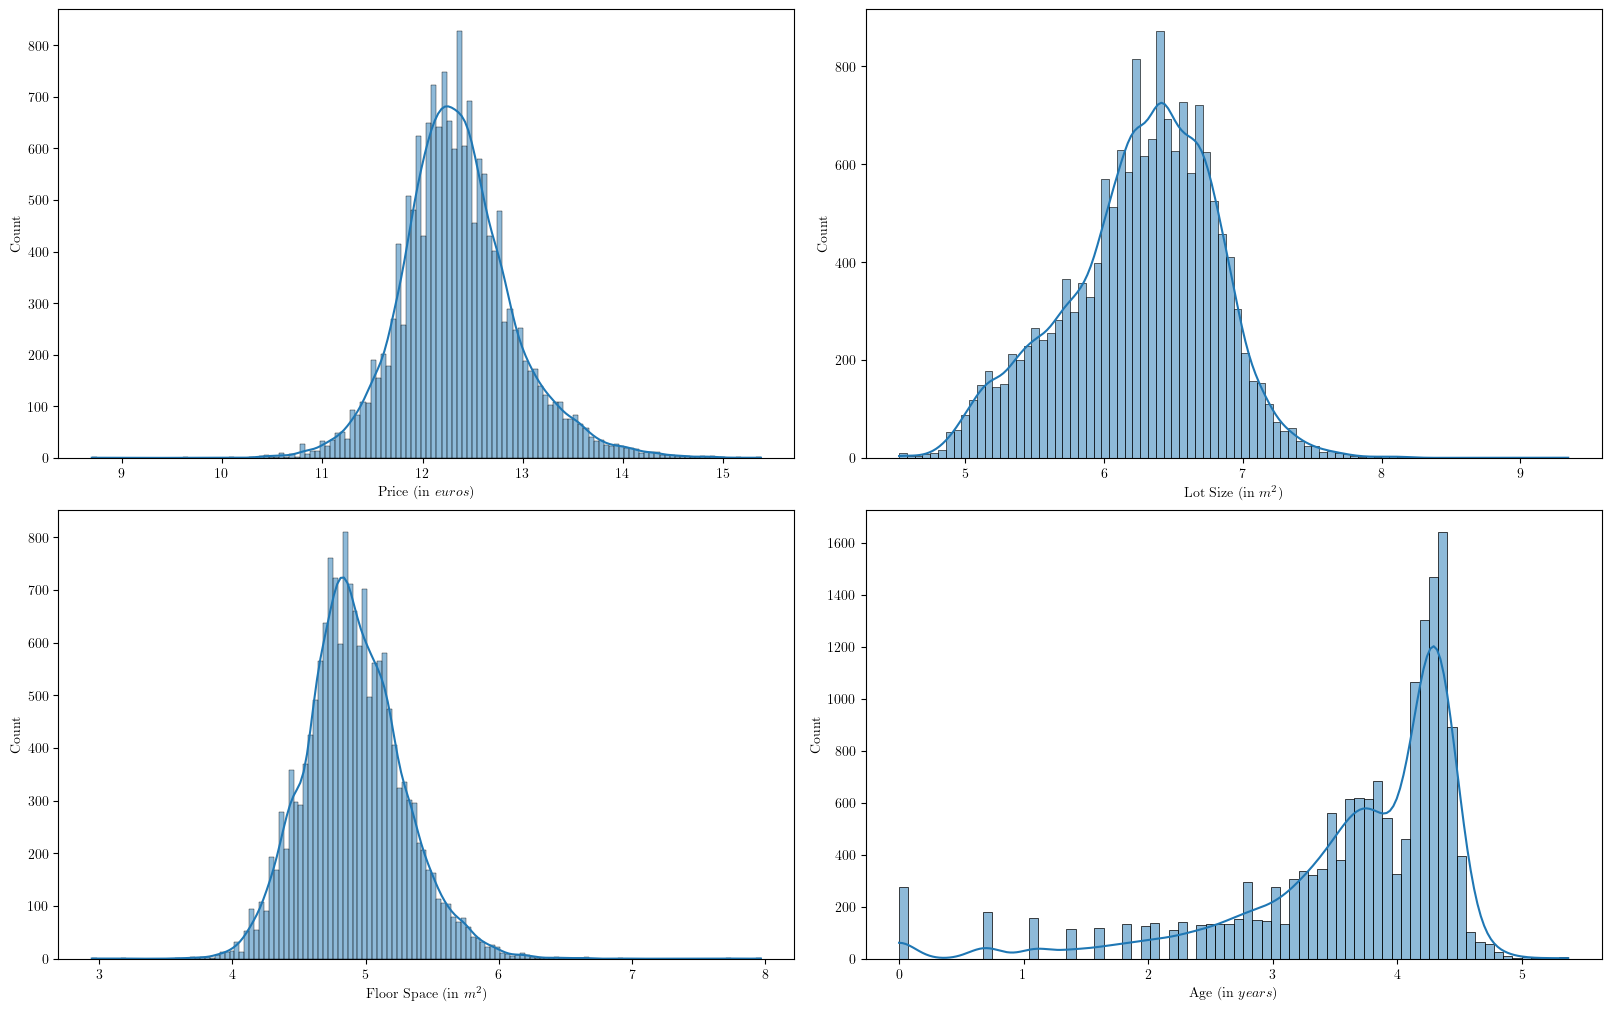

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(16,10), layout="constrained")

sns.histplot(data=data_log['price'], kde=True, ax=ax[0,0])
sns.histplot(data=data_log['lot_size'], kde=True, ax=ax[0,1])
sns.histplot(data=data_log['floor_space'], kde=True, ax=ax[1,0])
sns.histplot(data=data_log['age'], kde=True, ax=ax[1,1])


ax[0,0].set_xlabel('Price (in $euros$)')
ax[0,1].set_xlabel('Lot Size (in $m^2$)')
ax[1,0].set_xlabel('Floor Space (in $m^2$)')
ax[1,1].set_xlabel('Age (in $years$)')

#plt.savefig('Plots/distribution_linear.png')
plt.show()

#### Comparing Original Price and Log Price

The average prices are unconditional mean with variance $\mathbb{V}ar(Y)$.

The common pirce components are conditional mean with variance $\mathbb{E}[Var(Y|X)]$.

Based on the law of total variance
$$
\mathbb{V}ar(Y) = \mathbb{E}[Var(Y|X)] + \mathbb{V}ar(\mathbb{E}[Y|X]),
$$
the $\mathbb{V}ar(\mathbb{E}[Y|X])$ part is excluded, thus the common price component has smaller volatility.

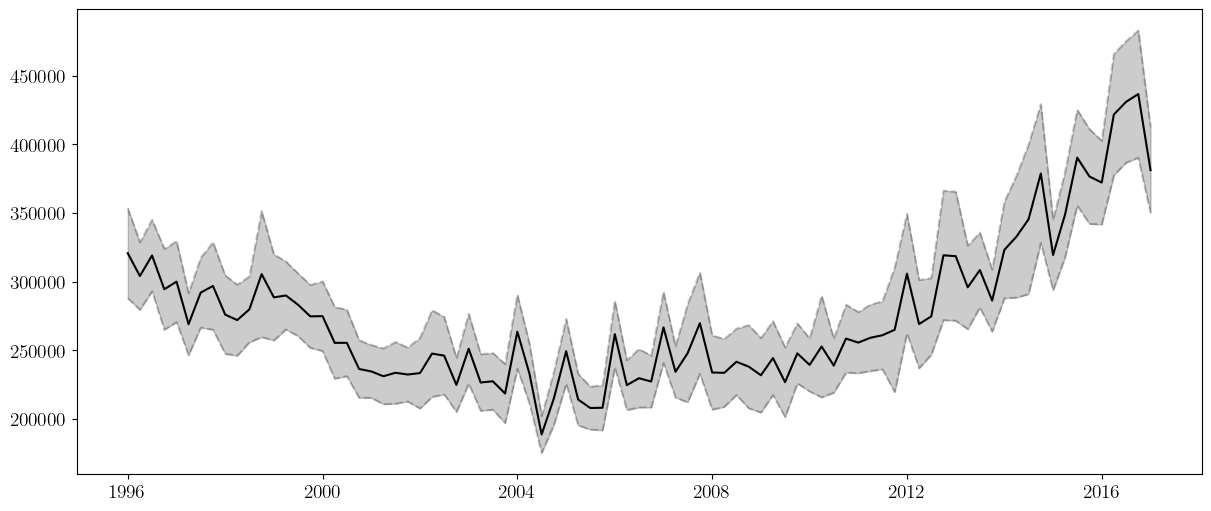

In [13]:
# linear price
average_price = data.groupby(data.index, sort=True)['price'].mean()
x_axis = average_price.index.to_timestamp()
std = data.groupby(data.index, sort=True)['price'].std()
margin_of_error = 1.96 * (std / np.sqrt(N))  # 1.96 is the Z-score for a 95% confidence interval

# log price
average_log_price = data_log.groupby(data_log.index, sort=True)['price'].mean()
std_log = data_log.groupby(data_log.index, sort=True)['price'].std()
margin_of_error_log = 1.96 * (std_log / np.sqrt(N))  # 1.96 is the Z-score for a 95% confidence interval

color = 'black'
plt.figure(figsize=(12, 5), layout="constrained")
plt.plot(x_axis, average_price, color=color)
plt.fill_between(x_axis, 
                 average_price - margin_of_error, 
                 average_price + margin_of_error, 
                 color=color, alpha=0.2)
plt.plot(x_axis, average_price + margin_of_error, color=color, alpha=0.2, linestyle='--')
plt.plot(x_axis, average_price - margin_of_error, color=color, alpha=0.2, linestyle='--')

#plt.title('Average Price with 95$\%$ Confidence Interval', fontsize=fs)
#plt.xlabel('Time Period', fontsize=fs)
#plt.ylabel('Price', fontsize=fs)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('Plots/average_price_per_quarter.png', dpi=600)
plt.show()